# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Shiva Kumar Tekumatla (stekumatla@wpi.edu)

MS Robotics Engineering,

Worcester Polytechnic Institute

RBE/CS549 in Fall-2022.


## Phase 1




### Get the BSDS500 dataset

In [2]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

--2022-08-20 15:14:04--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812060 (793K) [application/octet-stream]
Saving to: ‘BSDS500.tar.xz’

BSDS500.tar.xz      100%[===================>] 793.03K  3.15MB/s    in 0.2s    

2022-08-20 15:14:05 (3.15 MB/s) - ‘BSDS500.tar.xz’ saved [812060/812060]

x BSDS500/
x BSDS500/CannyBaseline/
x BSDS500/CannyBaseline/1.png
x BSDS500/CannyBaseline/10.png
x BSDS500/CannyBaseline/2.png
x BSDS500/CannyBaseline/3.png
x BSDS500/CannyBaseline/4.png
x BSDS500/CannyBaseline/5.png
x BSDS500/CannyBaseline/6.png
x BSDS500/CannyBaseline/7.png
x BSDS500/CannyBaseline/8.png
x BSDS500/CannyBaseline/9.png
x BSDS500/GroundTruth/
x BSDS500/GroundTru

In [4]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2022-08-20 15:16:06--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz’

TxtFiles.tar.xz     100%[===================>]  54.08K  --.-KB/s    in 0.01s   

2022-08-20 15:16:06 (4.02 MB/s) - ‘TxtFiles.tar.xz’ saved [55376/55376]

x TxtFiles/
x TxtFiles/DirNamesTest.txt
x TxtFiles/DirNamesTrain.txt
x TxtFiles/LabelsTest.txt
x TxtFiles/LabelsTrain.txt
mv: rename TxtFiles/ to /content/data/: No such file or directory


In [101]:
import numpy as np
import cv2
import scipy as sp
import math
from scipy import signal,ndimage
import imutils 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
all_filters = []  #stores all the filterbanks

In [102]:
"""Plotting function for all the subplots"""
def plotting(rows=2,columns=10,figure_size=(100,100)): 
    fig,ax = plt.subplots(rows,columns,figsize=figure_size,gridspec_kw = {'wspace':0.1, 'hspace':0.1})
    [axi.set_axis_off() for axi in ax.ravel()]
    return fig,ax

1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

In [103]:
class DoG: # Difference of Gaussian Filter bank 
    def __init__(self,scales=[1,2],orientations=16,size_x=10,size_y=10) -> None:
        """Input : Image path , Sigma of Gaussian , Number of orientations, Gaussian Size in X and Y directions """
        self.pi = math.pi
        self.scales = scales
        self.orientations = orientations
        self.all_angles = np.linspace(0,360,self.orientations)
        self.size_x = size_x 
        self.size_y = size_y 
        self.arr_x = [(i-self.size_x//2) for i in range(self.size_x)]
        self.arr_y = [(i-self.size_x//2) for i in range(self.size_x)]
        self.sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
        self.sobel_y = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
    def gaussian_kernel(self,scale):
        """Generating a gaussian filter of a given size and standard deviation
        Implemented as given in the below paper :
        https://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf """
        self.G2D = lambda x,y,std: (1/(2*self.pi*(std**2))) * math.exp(-((x**2)+(y**2))/(2*(std**2)))
        gaussian_arr = np.asarray([self.G2D(x,y,scale) for x in self.arr_x for y in self.arr_y])
        return gaussian_arr.reshape(self.size_x,self.size_y)

    def filter(self,scale):
        """Applies Sobel Kernel operator on the gaussian kernel"""
        gaussian = self.gaussian_kernel(scale)
        # Gx = signal.convolve2d(gaussian,self.sobel_x)
        # Gy = signal.convolve2d(gaussian,self.sobel_y)
        # return np.sqrt(Gx**2+Gy**2)
        return signal.convolve2d(gaussian,self.sobel_x)
    def filter_bank(self):
        bank = []
        for scale in self.scales:
            for angle in self.all_angles:
                bank.append(ndimage.rotate(self.filter(scale),angle))
        return bank 

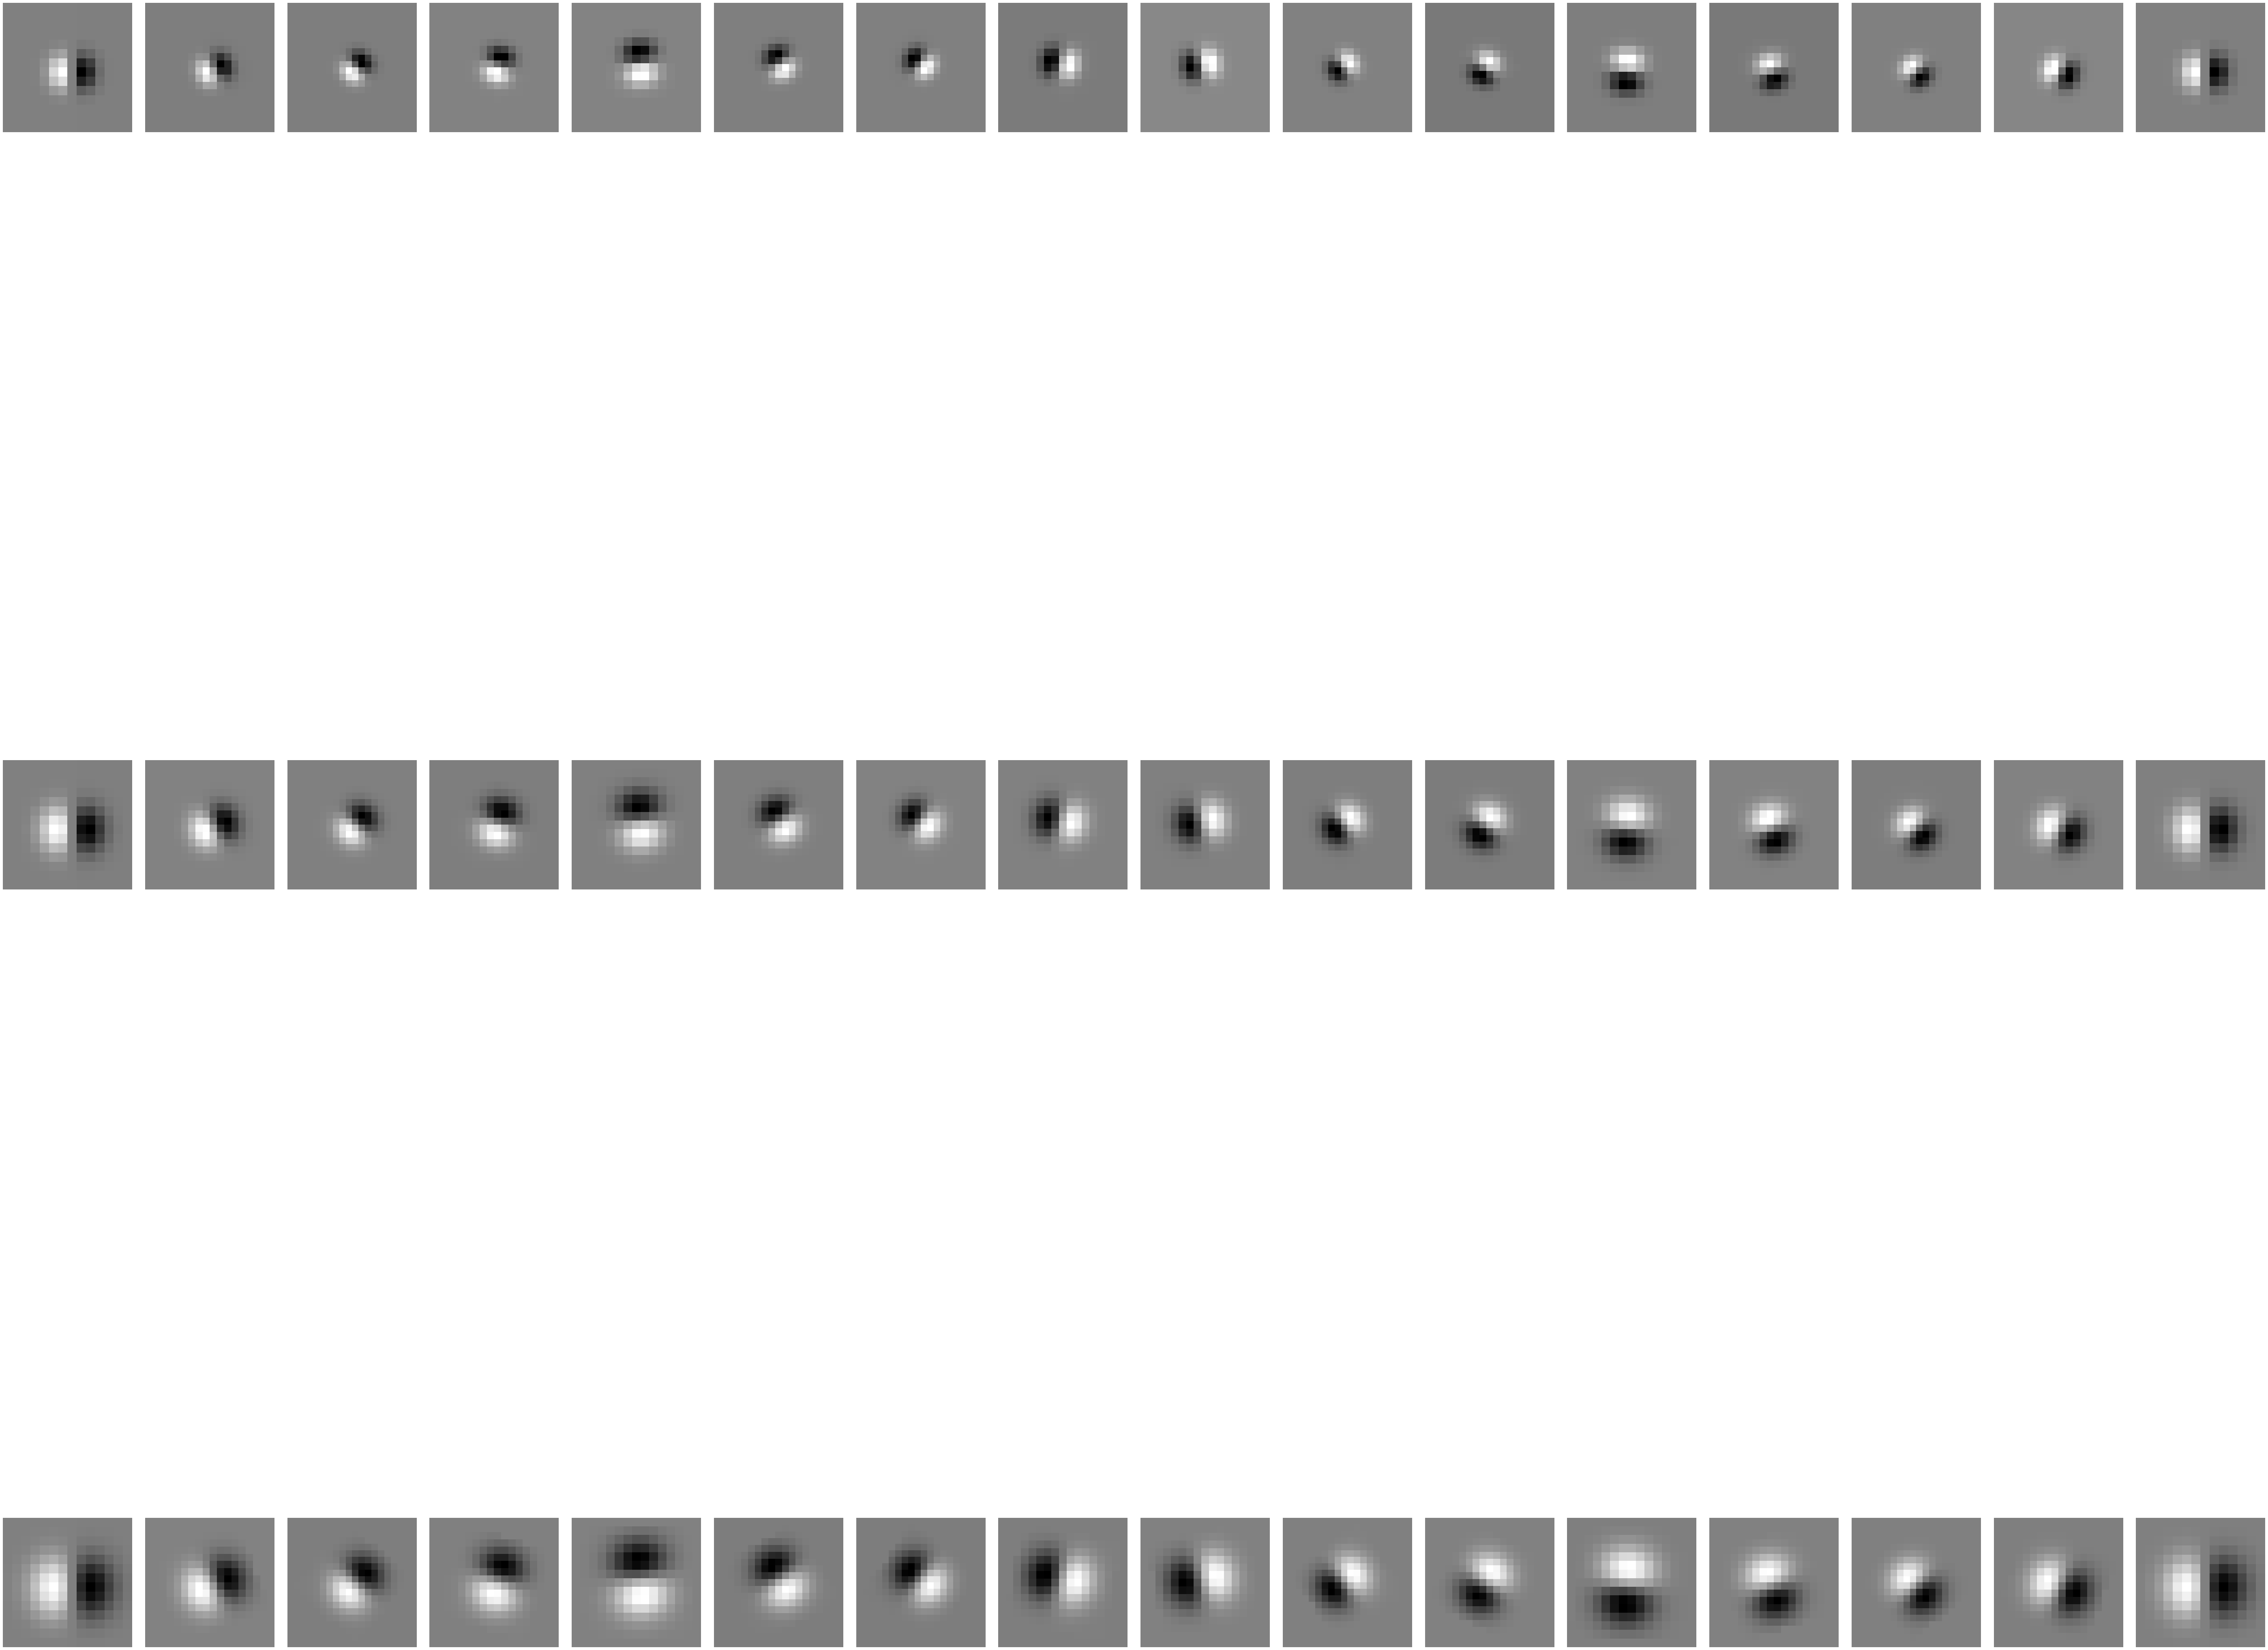

In [104]:
S = [1,1.5,2] #scales 
O = 16      #Number of Orientations
X = Y = 12 #Kernel size  - Keep both the values same for now 
dog = DoG(scales=S,orientations=O,size_x=X,size_y=Y)
bank = dog.filter_bank()
fig,ax = plotting(rows=len(S),columns=O,figure_size=(100,100))
k=0
for i in range(len(S)):
    for j in range(O):
        ax[i][j].imshow(bank[k],cmap="gray")
        k+=1
all_filters.extend(bank)


1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


In [105]:

class LM:
    def __init__(self,size=10) -> None:
        self.size = size # must be an odd number 
        self.orientations = np.linspace(0,360,6) # Total of 6 orientations are considered   
        self.size_x = self.size
        self.size_y = self.size
        self.arr_x = [(i-self.size_x//2) for i in range(self.size_x)]
        self.arr_y = [(i-self.size_x//2) for i in range(self.size_x)]
        
    def LoG(self,scale):
        """This method returns the LoG filter. More details about this can be found at:
        https://academic.mu.edu/phys/matthysd/web226/Lab02.htm """
        self.LoG2D= lambda x,y,std: (-1/(math.pi*std**4))  *  (1- ((x**2+y**2)/(2*std**2)) )*math.exp(-((x**2+y**2)/(2*std**2)))
        log_arr = np.asarray([self.LoG2D(x,y,scale) for x in self.arr_x for y in self.arr_y])
        return log_arr.reshape(self.size_x,self.size_y)
    def gaussian2d(self,scale_x,scale_y):
        """This is written based on:
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution
        """
        self.G2D = lambda x,y,std_x,std_y : (1 / (2*math.pi*std_x*std_y)) * math.exp(-0.5* ( ( (x/std_x) **2) + ( (y/std_y) **2) ) )
        gaussian_array = np.asarray([self.G2D(x,y,scale_x,scale_y) for x in self.arr_x for y in self.arr_y])
        return gaussian_array.reshape(self.size_x,self.size_y)
    
    def filter(self,basic_scales):
        """The LM set is a multi scale, multi orientation filter bank with 48 filters. 
        It consists of first and second derivatives of Gaussians at 6 orientations and 3 scales making a total of 36; 
        8 Laplacian of Gaussian (LOG) filters; and 4 Gaussians."""
        sobel= np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
        bank =[]
        for angle in self.orientations:
            for i in range(len(basic_scales)-1):  #The first and second derivative filters occur at the first three scales with an elongation factor of 3
                scale = basic_scales[i]
                scale_x = scale 
                scale_y = 3*scale_x
                g2d = self.gaussian2d(scale_x,scale_y)
                g2d = ndimage.rotate(g2d,angle)
                first_ord_g2d = signal.convolve2d(g2d,sobel) # first order 
                second_ord_g2d = signal.convolve2d(first_ord_g2d,sobel) # first order 
                bank.append(first_ord_g2d) 
                bank.append(second_ord_g2d) 
        [bank.append(self.gaussian2d(scale,scale)) for scale in basic_scales] #Gaussians occur at the four basic scales
        basic_scales = np.concatenate((basic_scales,basic_scales*2)) 
        [bank.append(self.LoG(scale)) for scale in basic_scales]  # 8 LOG filters occur at sigma and 3sigma
        return bank 

    def LMS(self):
        """In LM Small (LMS), the filters occur at basic scales = {1,√2,2,2√2}"""
        root_2 = np.sqrt(2)
        basic_scales = np.array([1,root_2,2,2*root_2])
        return self.filter(basic_scales)
    def LML(self):
        """For LM Large (LML), the filters occur at the basic scales {√2,2,2√2,4}"""
        root_2 = np.sqrt(2) 
        basic_scales = np.array([root_2,2,2*root_2,4])
        return self.filter(basic_scales)
        

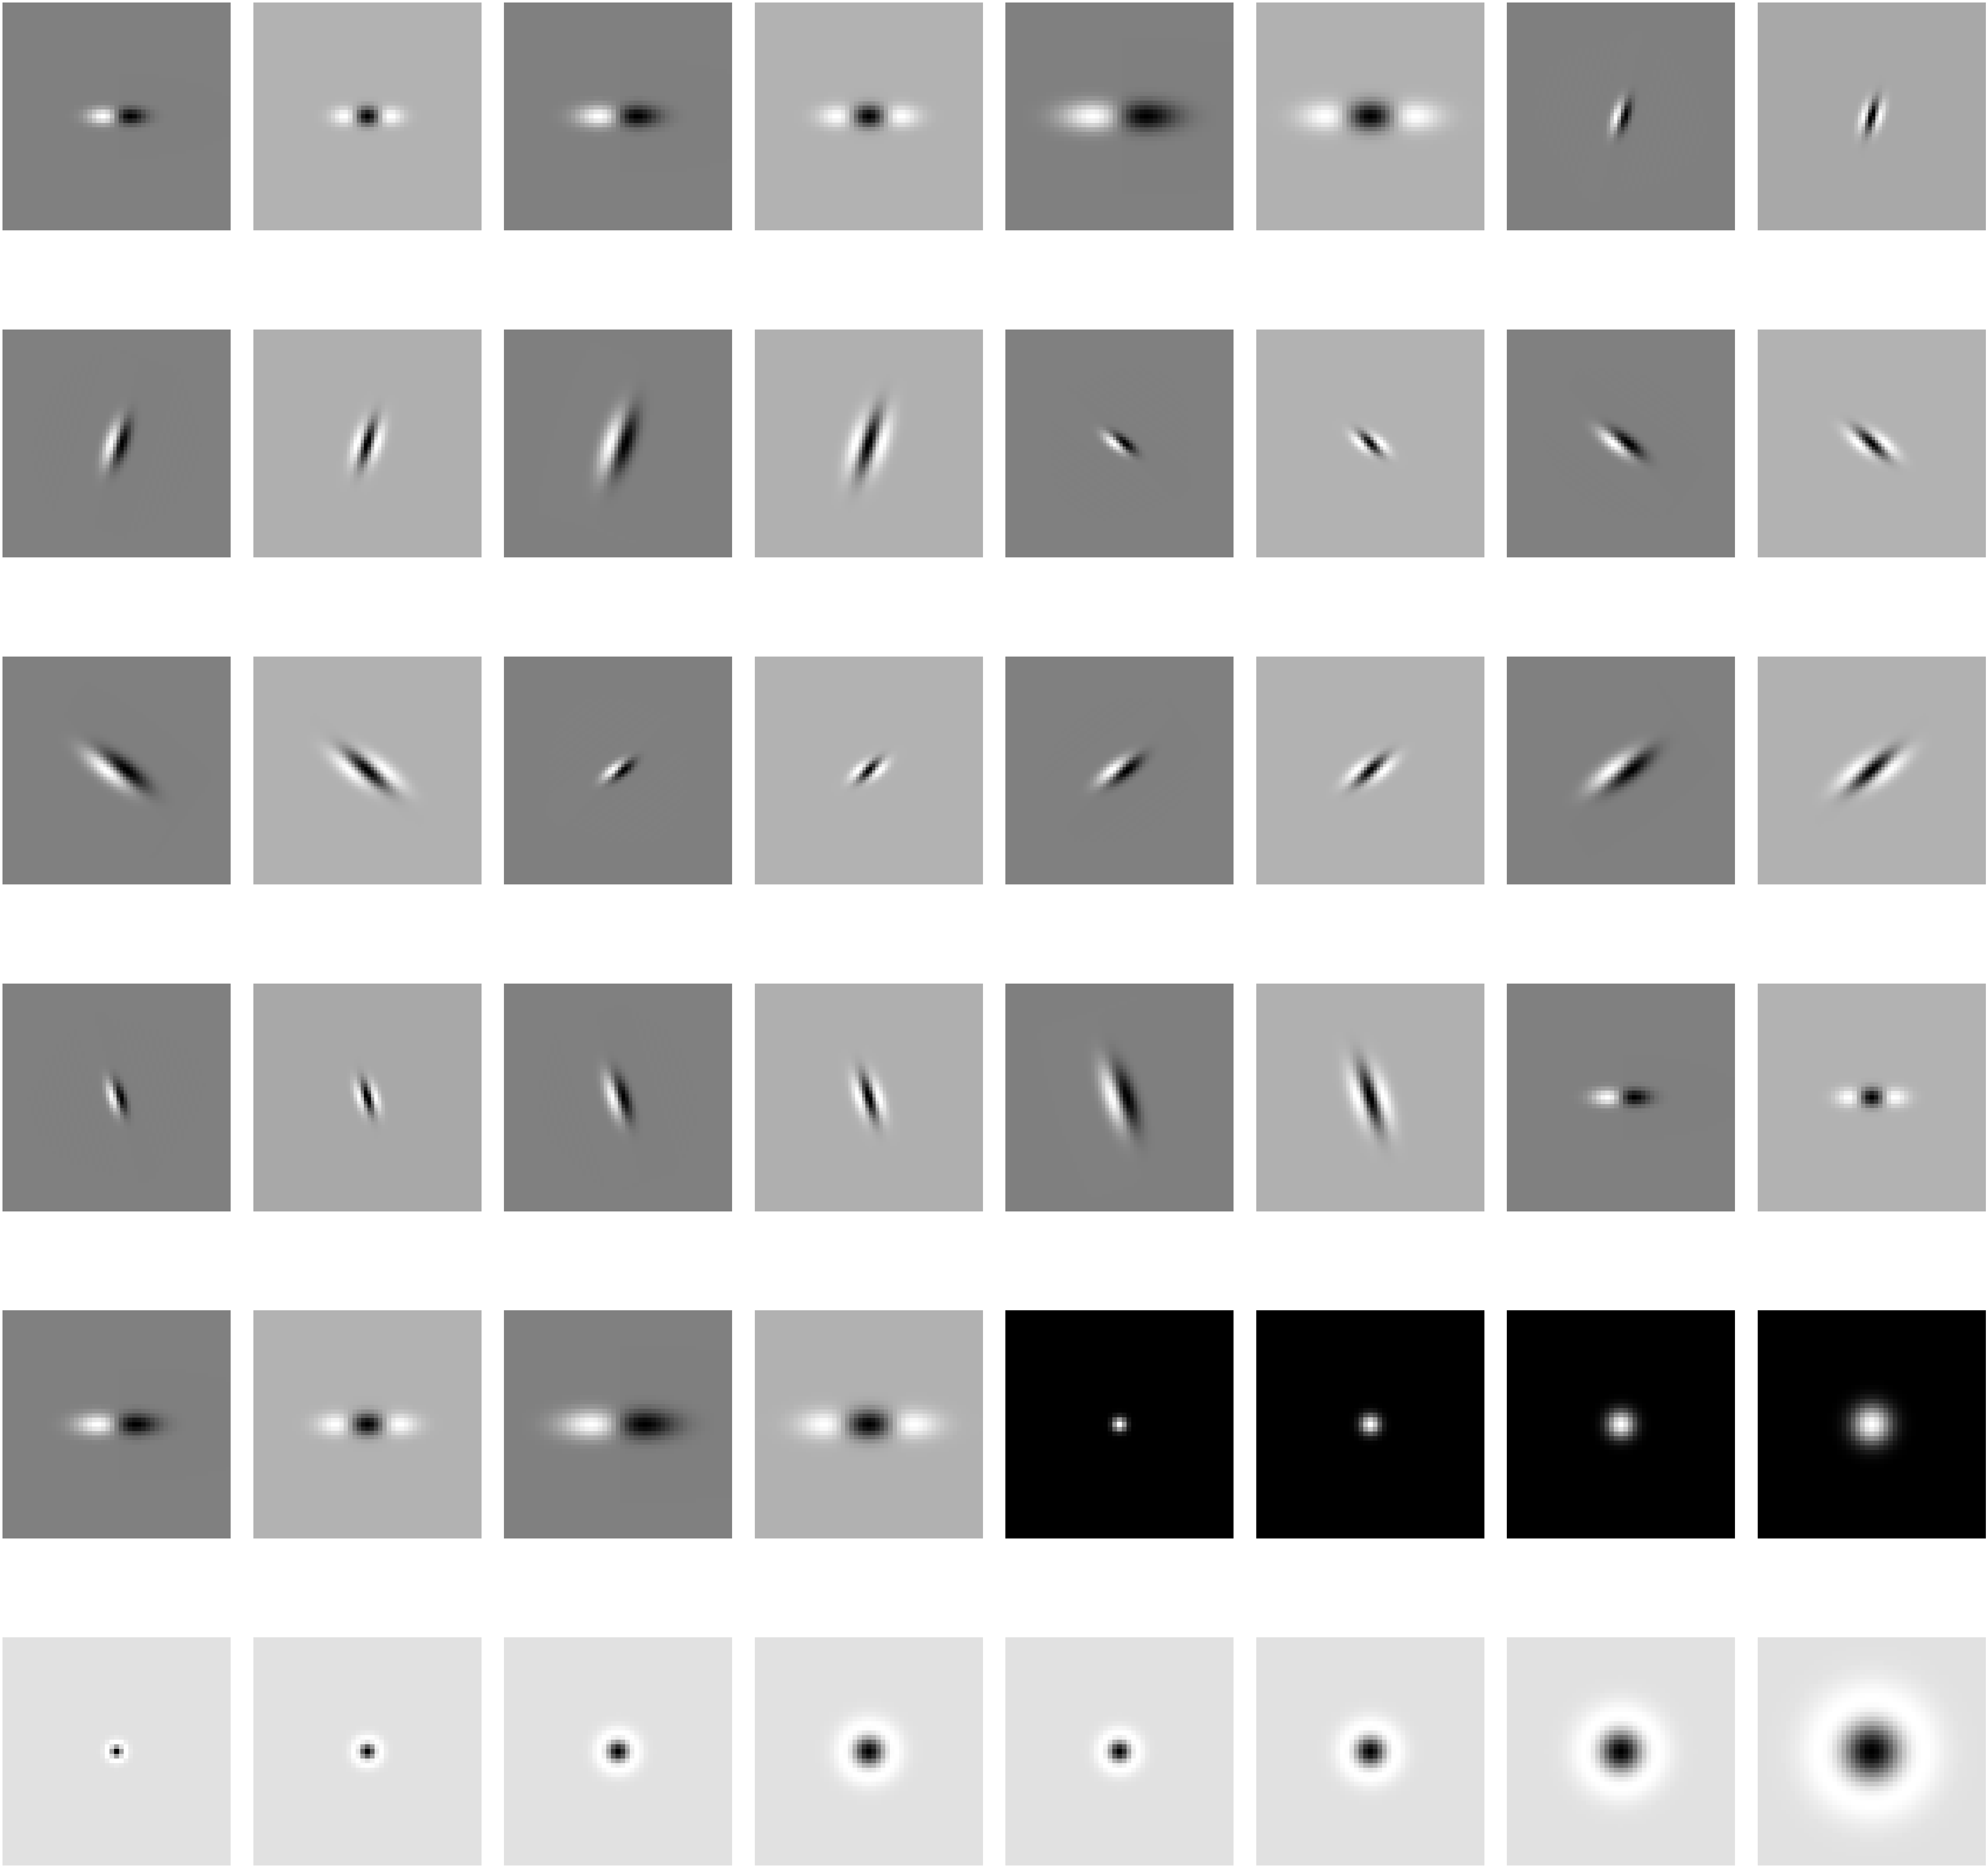

In [106]:
lm = LM(size=49)
bank = lm.LMS()
fig,ax = plotting(rows=6,columns=8,figure_size=(100,100))
k=0
for i in range(6):
    for j in range(8):
        ax[i][j].imshow(bank[k],cmap="gray")
        k+=1
all_filters.extend(bank)

1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


In [107]:
class Gabor:
    def __init__(self,x,y,sigma,theta,_lambda,psi,gamma) -> None:
        self.x = x  #Kernel size in x 
        self.y = y  #kernel size in y
        self.sigma = sigma # standard deviation 
        self.theta = theta # angle 
        self._lambda =_lambda # wavelength 
        self.psi = psi # Phase offset 
        self.gamma = gamma # Aspect ratio
        (y_grid, x_grid) = np.meshgrid(np.arange(-y, y + 1), np.arange(-x, x+1))
        self.x_rot = x_grid * np.cos(theta) + y_grid * np.sin(theta) #rotation part
        self.y_rot = -x_grid * np.sin(theta) + y_grid * np.cos(theta) #rotation part
    def filter(self):
        """Based on wikipedia article:
        https://en.wikipedia.org/wiki/Gabor_filter """
        return np.exp(-0.5 * (self.x_rot ** 2/self.sigma**2+self.y_rot ** 2/self.sigma**2))*np.cos(2*np.pi/self._lambda*self.x_rot+self.psi)

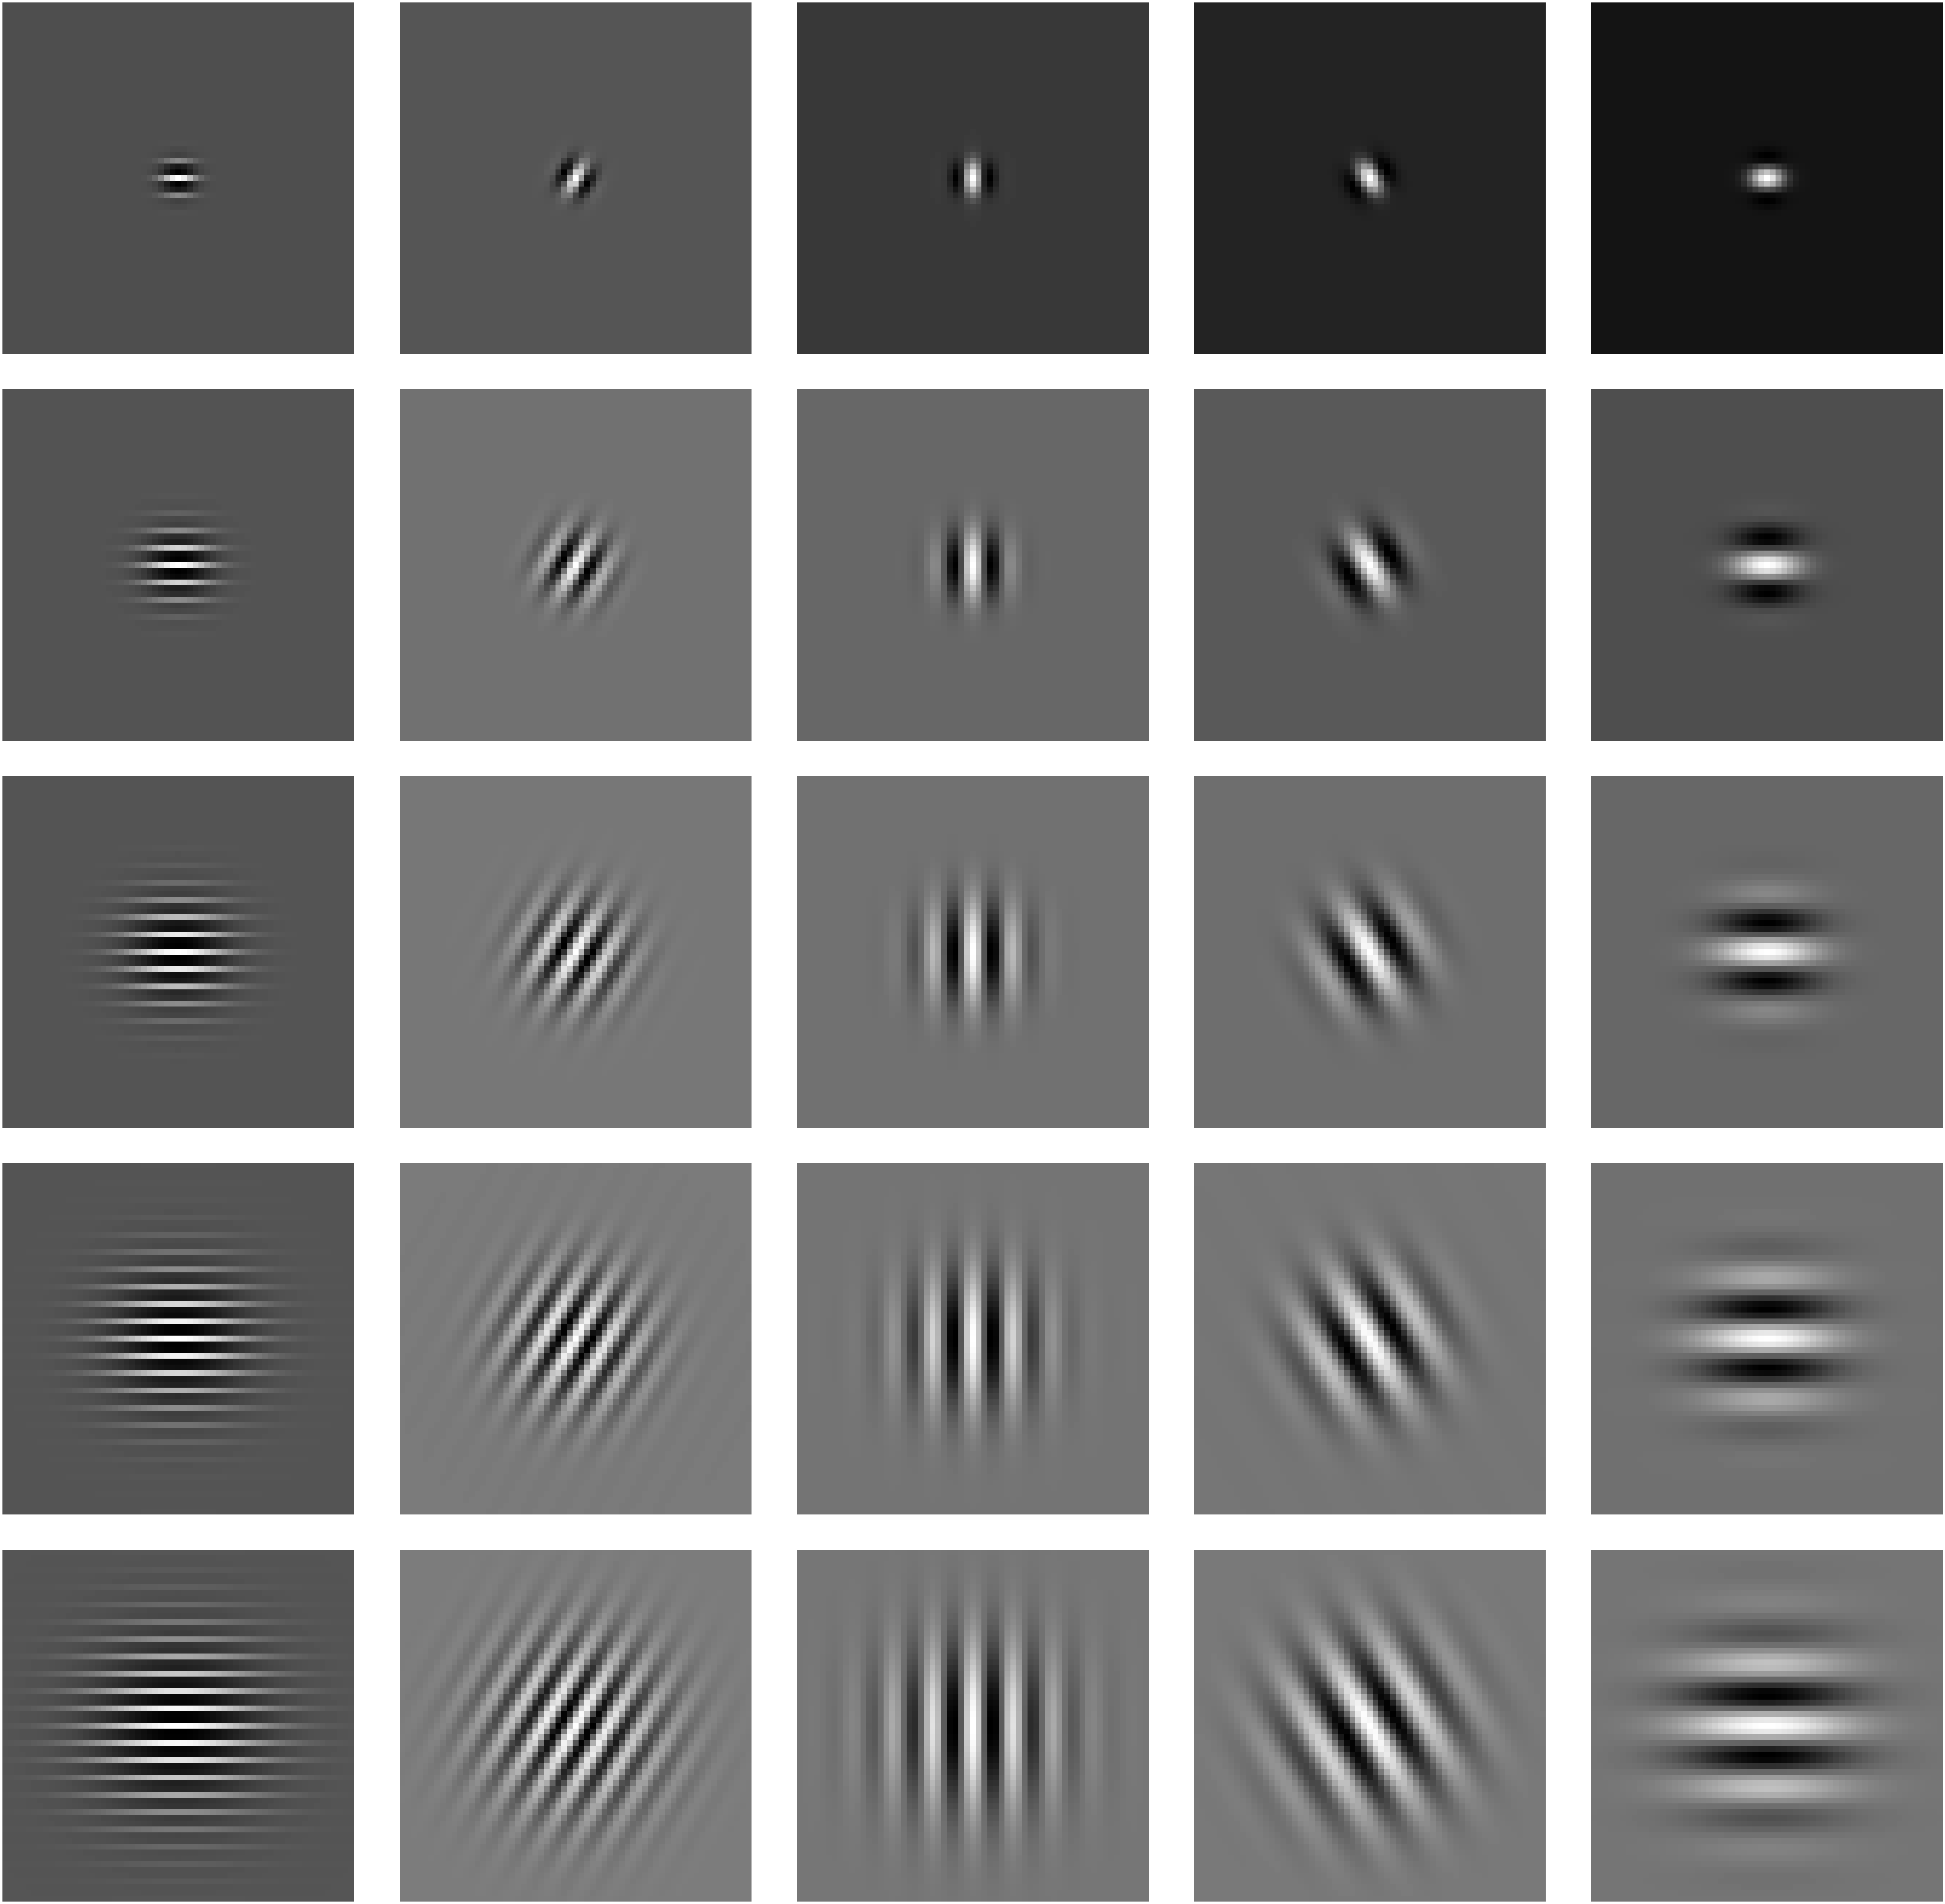

In [108]:
_lambda = [3,5,7,9,11] 
size = 30
gamma =0.5
sigma = [2,4,6,8,10]
pi = math.pi
thetas  = [0,pi/3,pi/2,2*pi/3,pi ] #list(np.linspace(0,2*math.pi,len(_lambda)))
bank =[]
for sig in sigma:
    for lam,theta in zip(_lambda,thetas):
        gabor = Gabor(size,size,sig,theta,lam,0,gamma)
        bank.append(gabor.filter())
fig,ax = plotting(rows=len(sigma),columns=len(_lambda),figure_size=(100,100))
k=0
for i in range(len(sigma)):
    for j in range(len(_lambda)):
        ax[i][j].imshow(bank[k],cmap="gray")
        k+=1
all_filters.extend(bank) 

1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


1. Generate Brightness Map
2. Perform brightness binning


1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



1. Generate Color Map
2. Perform color binning or clustering





1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"




1. Read Sobel Baseline
2. use command "cv2.imread(...)"





1. Read Canny Baseline
2. use command "cv2.imread(...)"





1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



## Phase 2

### Neural Network Construction

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    loss = ...
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs: 
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      
  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################
     
      return out
      

ModuleNotFoundError: No module named 'torch'

In [ ]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

def SetupAll(CheckPointPath):
    """
    Inputs: 
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/data/TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)
        
    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100 
    
    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels
    

def ReadDirNames(ReadPath):
    """
    Inputs: 
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames

    
def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs: 
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch
   
    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels 
    """
    I1Batch = []
    LabelBatch = []
    
    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)
        
        ImageNum += 1
    	
    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        I1, Label = TrainSet[RandIdx]

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))
        
    return torch.stack(I1Batch), torch.stack(LabelBatch)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)              

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs: 
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10) 
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = ...

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')
        
    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)
            
            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()
            
            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'
                
                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('LossEveryIter', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')
        


# Default Hyperparameters
NumEpochs = 50
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 1
LoadCheckPoint = 0
CheckPointPath = "/content/Checkpoints/"
LogsPath = "/content/Logs"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

Files already downloaded and verified
ERROR: Train Labels do not exist in /content/data/TxtFiles/LabelsTrain.txt


SystemExit: 

/Users/ric137k/.pyenv/versions/3.9.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Test your neural network

In [ ]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """   
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img
    
def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """    
    I1 = Img
    
    if(I1 is None):
        # OpenCV returns empty list if image is not read! 
        print('ERROR: Image I1 cannot be read')
        sys.exit()
        
    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1
                

def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs: 
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10) 
    
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))
    
    OutSaveT = open(LabelsPathPred, 'w')

    for count in tqdm(range(len(TestSet))): 
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        PredT = torch.argmax(model(Img)).item()

        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs: 
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())
        
    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "/content/Checkpoints/0a100model.ckpt"
LabelsPath = "/content/data/TxtFiles/LabelsTest.txt"
TestSet = CIFAR10(root='data/', train=False)


# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = '/content/data/TxtFiles/PredOut.txt' # Path to save predicted labels

TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

# Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
ConfusionMatrix(LabelsTrue, LabelsPred) 